In [79]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import os
import numpy as np

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import random

In [80]:
seed = 42
np.random.seed =  seed

In [81]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [82]:
TRAIN_PATH = "./Data/data-science-bowl-2018/stage1_train/"
TEST_PATH = "./Data/data-science-bowl-2018/stage1_test/"


In [83]:
train_ids = next( os.walk(TRAIN_PATH))[1]
test_ids = next( os.walk(TEST_PATH))[1]


In [84]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

### Resizing training images and masks

- Data is saved to X_train and Y_train -> just load them

In [85]:
# for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)): #tqdm shows progress bar
#     path = TRAIN_PATH + id_
#     img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     X_train[n] = img  # Fill empty X_train with values from img
#     mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

#     for mask_file in next(os.walk(path + '/masks/'))[2]:
#         mask_ = imread(path + '/masks/' + mask_file)
#         mask_ = np.expand_dims(resize(
#             mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
#         mask = np.maximum(mask, mask_)

#     Y_train[n] = mask


In [86]:
# np.save("Train_Images", X_train)
# np.save("Train_Masks", Y_train)

X_train = np.load("Train_Images.npy")
Y_train = np.load("Train_Masks.npy")

### Resizing test images


In [87]:
sizes_test = []

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):  # tqdm shows progress bar
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img= resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img



100%|██████████| 65/65 [00:01<00:00, 41.71it/s]


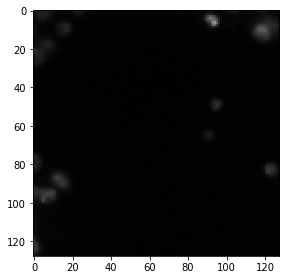

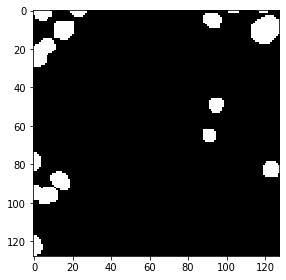

In [88]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

## Build the model

In [89]:
inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

s = Lambda(lambda x: x / 255)(inputs)


# Contraction path
c1 = Conv2D(
    16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)

c5 = Conv2D(256, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c5)

# Expansive path
u6 = Conv2DTranspose(
    128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(
    64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(
    32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(
    16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 128, 128, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 16) 448         lambda_3[0][0]                   
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 128, 128, 16) 0           conv2d_39[0][0]                  
____________________________________________________________________________________________

## Model Checkpoint

In [90]:
checkpointer = ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
    EarlyStopping(patience=2, monitor='val_loss'),
    TensorBoard(log_dir='logs')
]

In [91]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
38/38 [==============================] - 59s 1s/step - loss: 0.6313 - accuracy: 0.6901 - val_loss: 0.2838 - val_accuracy: 0.8169
Epoch 2/25
38/38 [==============================] - 48s 1s/step - loss: 0.2999 - accuracy: 0.8159 - val_loss: 0.1938 - val_accuracy: 0.9127
Epoch 3/25
38/38 [==============================] - 47s 1s/step - loss: 0.1952 - accuracy: 0.9254 - val_loss: 0.1325 - val_accuracy: 0.9480
Epoch 4/25
38/38 [==============================] - 48s 1s/step - loss: 0.1471 - accuracy: 0.9459 - val_loss: 0.1181 - val_accuracy: 0.9534
Epoch 5/25
38/38 [==============================] - 48s 1s/step - loss: 0.1220 - accuracy: 0.9531 - val_loss: 0.1136 - val_accuracy: 0.9568
Epoch 6/25
38/38 [==============================] - 45s 1s/step - loss: 0.1148 - accuracy: 0.9570 - val_loss: 0.0994 - val_accuracy: 0.9612
Epoch 7/25
38/38 [==============================] - 45s 1s/step - loss: 0.1014 - accuracy: 0.9619 - val_loss: 0.1083 - val_accuracy: 0.9610
Epoch 8/25
38/38 [==

### Test the trained model


In [92]:
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


3/3 [==============================] - 1s 194ms/step


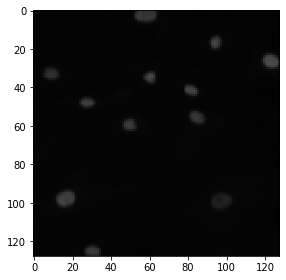

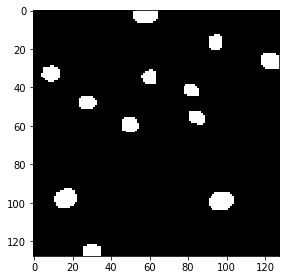

D:\Python_39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


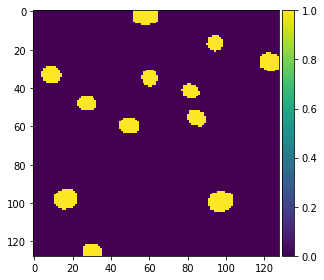

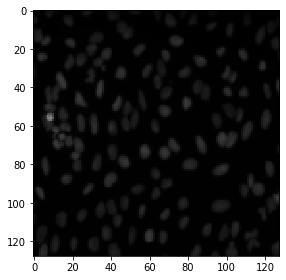

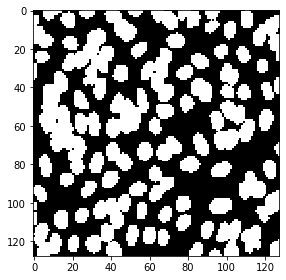

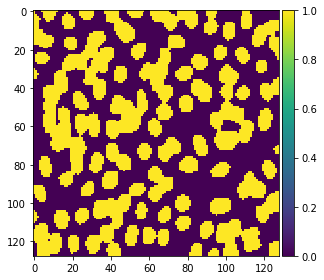

In [93]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()


Der Befehl "tensorboard" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [97]:
!tensorboard --logdir = logs / --host localhost --port 8088


TensorFlow installation not found - running with reduced feature set.
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--reuse_port BOOL] [--load_fast {false,auto,true}]
                   [--extra_data_server_flags EXTRA_DATA_SERVER_FLAGS]
                   [--grpc_creds_type {local,ssl,ssl_dev}]
                   [--grpc_data_provider PORT] [--purge_orphaned_data BOOL]
                   [--db URI] [--db_import] [--inspect] [--version_tb]
                   [--tag TAG] [--event_file PATH] [--path_prefix PATH]
                   [--window_title TEXT] [--max_reload_threads COUNT]
                   [--reload_interval SECONDS] [--reload_task TYPE]
                   [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [--wh